# GloFAS new reanalysis

Loading and processing GloFAS reanalysis

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr

from src.datasources import nihsa, glofas
from src.utils import blob

## Download, process, load

In [3]:
station_name = "wuroboki"

In [6]:
glofas.download_glofas_reanalysis_to_blob(station_name=station_name)

  0%|          | 0/46 [00:00<?, ?it/s]

ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1979.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1980.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1981.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1982.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1983.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1984.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1985.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1986.grib already exists in blob storage
ds-aa-nga-flooding/raw/glofas/reanalysis/glofas_raw_reanalysis_wuroboki_1987.grib already exists

In [94]:
glofas.process_glofas_reanalysis(station_name=station_name)

  0%|          | 0/46 [00:00<?, ?it/s]

In [95]:
df_ra = glofas.load_glofas_reanalysis(station_name=station_name)

In [105]:
df_ra

,time,dis24
0,1979-01-01,79.656250
1,1979-01-02,77.609375
2,1979-01-03,76.515625
3,1979-01-04,75.671875
4,1979-01-05,74.843750
...,...,...
16736,2024-10-27,1411.625000
16737,2024-10-28,1280.859375
16738,2024-10-29,1156.441406
16739,2024-10-30,1043.812500


In [99]:
df_nh = nihsa.load_wuroboki()

In [104]:
df_nh

,time,level
2,1954-05-25,398.0
3,1954-05-26,383.0
4,1954-05-27,389.0
5,1954-05-28,408.0
6,1954-05-29,404.0
...,...,...
27234,2024-12-27,458.0
27235,2024-12-28,455.0
27236,2024-12-29,451.0
27237,2024-12-30,457.0


In [134]:
df_compare = df_ra.merge(df_nh, how="left")

In [135]:
df_compare

,time,dis24,level
0,1979-01-01,79.656250,149.0
1,1979-01-02,77.609375,147.0
2,1979-01-03,76.515625,146.0
3,1979-01-04,75.671875,145.0
4,1979-01-05,74.843750,144.0
...,...,...,...
31277,2024-10-27,1411.625000,595.0
31278,2024-10-28,1280.859375,585.0
31279,2024-10-29,1156.441406,583.0
31280,2024-10-30,1043.812500,568.0


## Plot comparison

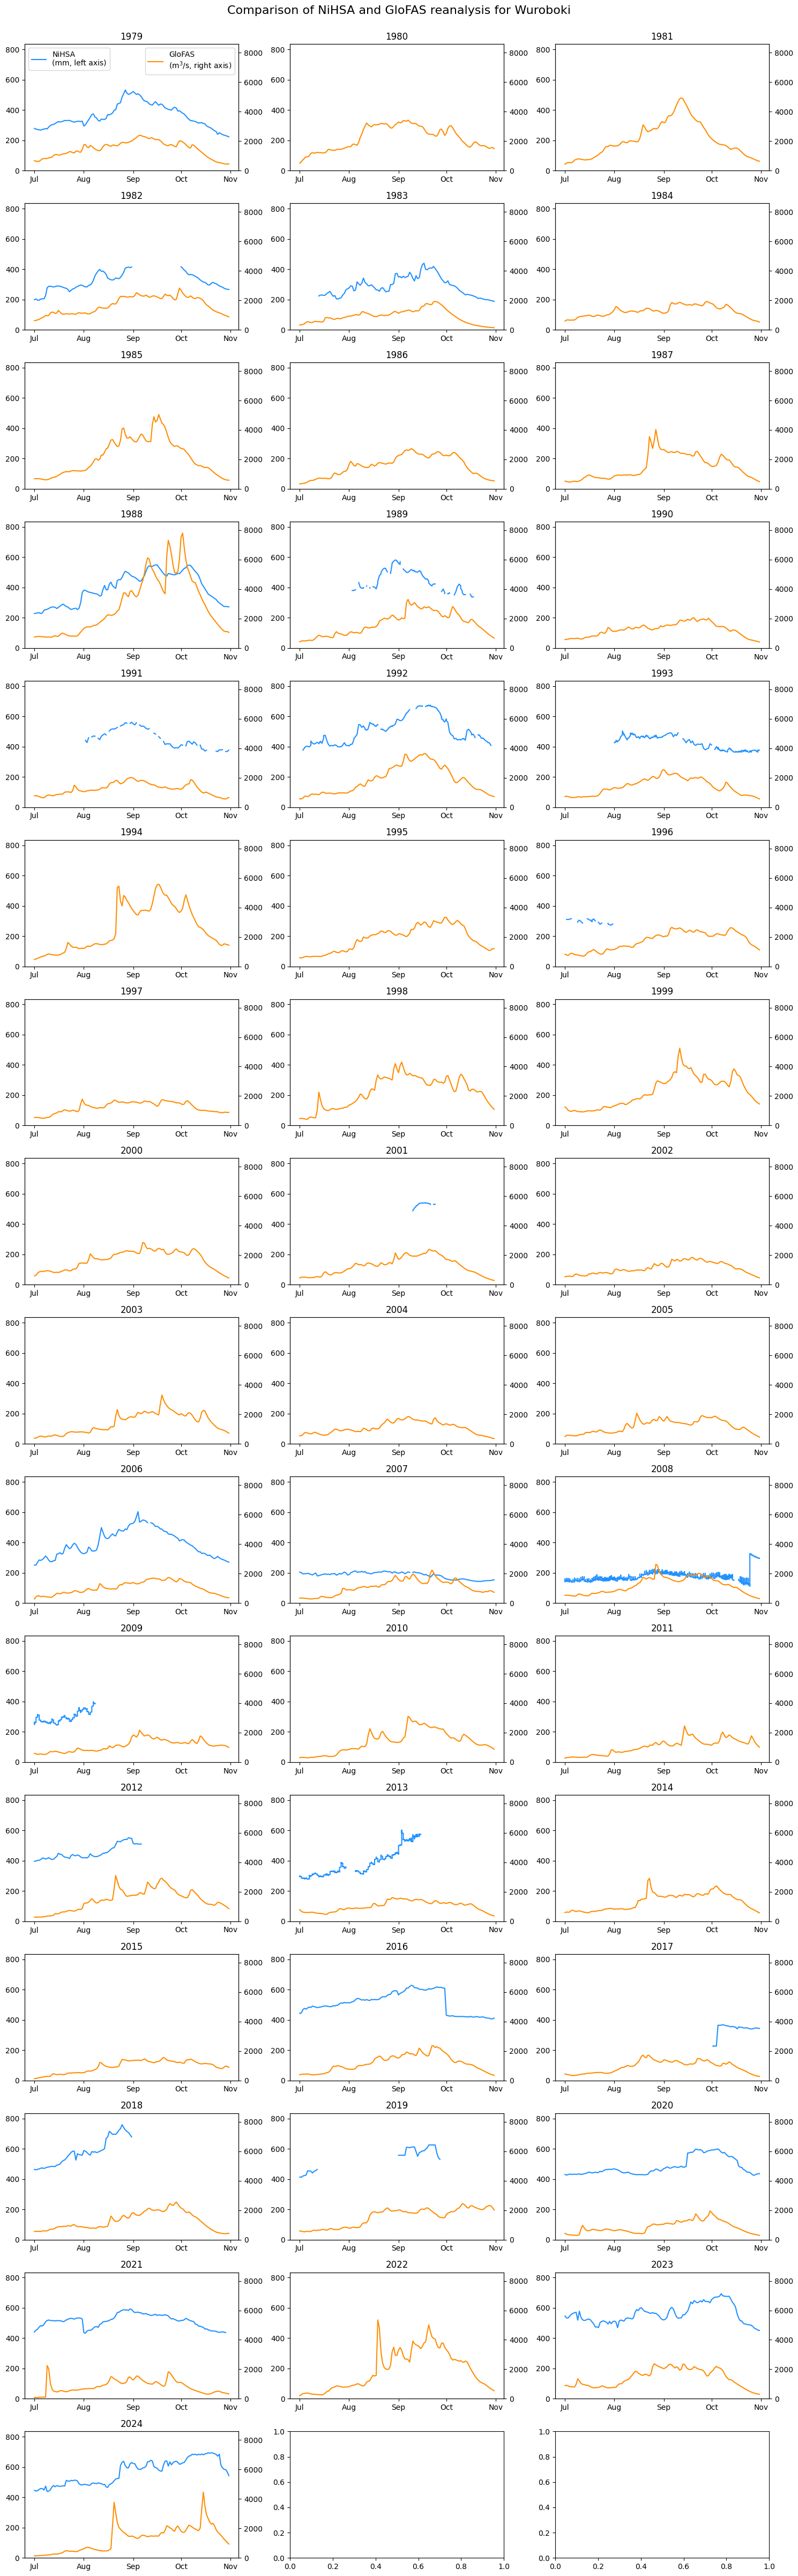

In [237]:
months = range(7, 11)
df_plot = df_compare[
    (df_compare["time"].dt.month.isin(months))
    # & (df_compare["time"].dt.year.isin(nihsa.WUROBOKI_COMPLETE_YEARS))
]

dis_max = df_plot["dis24"].max()
level_max = df_plot["level"].max()

n_years = df_plot["time"].dt.year.nunique()

ncols = 3
nrows = round(n_years / ncols) + 1

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3)
)
axes = axes.flatten()

for j, year in enumerate(df_plot["time"].dt.year.unique()):
    dff = df_plot[df_plot["time"].dt.year == year]
    ax = axes[j]
    ax2 = ax.twinx()

    ax.plot(
        dff["time"],
        dff["level"],
        color="dodgerblue",
        label="NiHSA\n(mm, left axis)",
    )
    ax.set_ylim(bottom=0, top=level_max * 1.1)

    ax2.plot(
        dff["time"],
        dff["dis24"],
        color="darkorange",
        label="GloFAS\n(m$^{3}$/s, right axis)",
    )
    ax2.set_ylim(bottom=0, top=dis_max * 1.1)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_title(year)

    if j == 0:
        ax.legend(loc="upper left")
        ax2.legend(loc="upper right")


fig.suptitle(
    f"Comparison of NiHSA and GloFAS reanalysis for {station_name.capitalize()}",
    fontsize=16,
    y=1,
)

plt.tight_layout()

plt.savefig(
    "temp/wuroboki_nihsa_glofas_comparison.png", dpi=200, bbox_inches="tight"
)

## Check correlations and yearly peaks

In [140]:
df_compare.corr()

,time,dis24,level
time,1.000000,-0.104751,0.273537
dis24,-0.104751,1.000000,0.431741
level,0.273537,0.431741,1.000000


In [156]:
df_peaks = df_compare.groupby(df_compare["time"].dt.year.rename("year")).agg(
    dis24_max=("dis24", "max"),
    dis24_max_date=("dis24", lambda x: df_compare.loc[x.idxmax(), "time"]),
    level_max=("level", "max"),
    level_max_date=(
        "level",
        lambda x: (
            df_compare.loc[x.idxmax(), "time"] if x.notna().any() else pd.NaT
        ),
    ),
)

For all years

In [172]:
df_peaks.corr()

,dis24_max,dis24_max_date,level_max,level_max_date
dis24_max,1.000000,-0.237596,-0.110596,-0.000819
dis24_max_date,-0.237596,1.000000,0.486702,0.254707
level_max,-0.110596,0.486702,1.000000,0.490125
level_max_date,-0.000819,0.254707,0.490125,1.000000


For complete years

In [177]:
df_peaks.loc[nihsa.WUROBOKI_COMPLETE_YEARS].corr()

,dis24_max,dis24_max_date,level_max,level_max_date
dis24_max,1.000000,-0.130591,-0.049523,-0.130661
dis24_max_date,-0.130591,1.000000,0.755940,0.999996
level_max,-0.049523,0.755940,1.000000,0.755662
level_max_date,-0.130661,0.999996,0.755662,1.000000


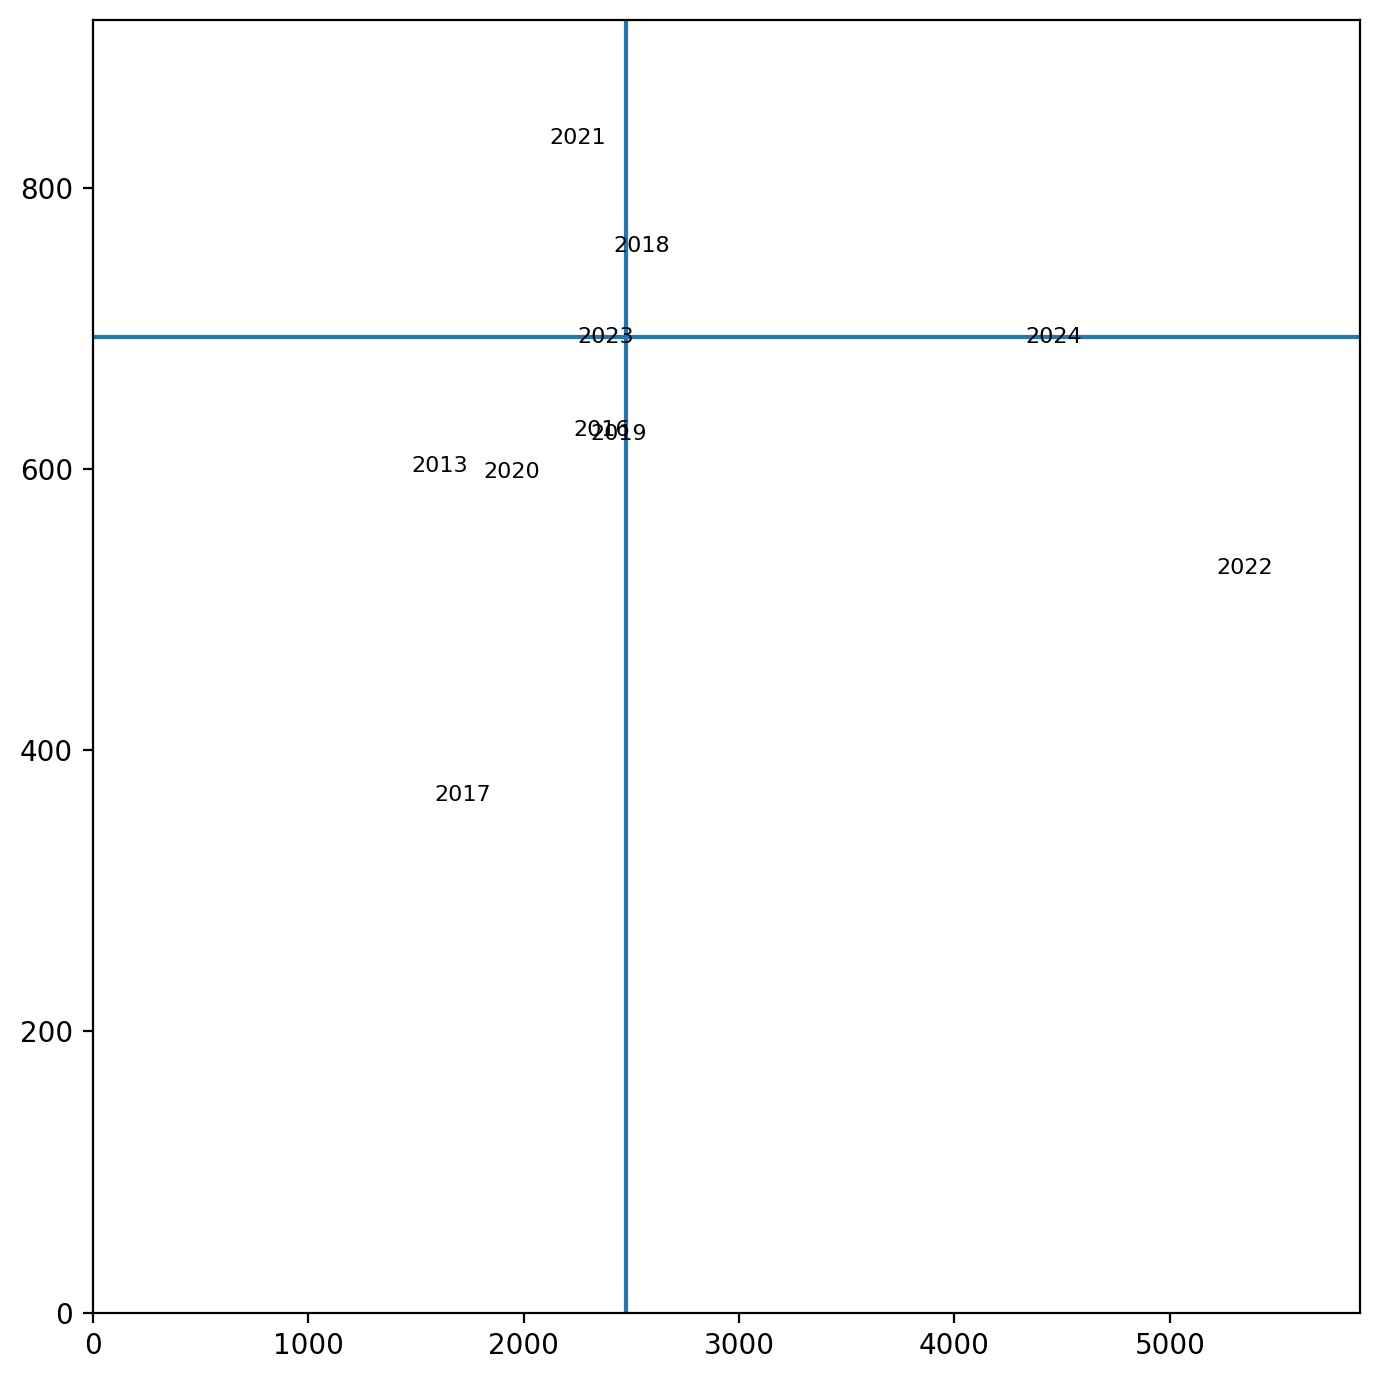

In [204]:
# df_plot = df_peaks.loc[nihsa.WUROBOKI_COMPLETE_YEARS].copy()
df_plot = df_peaks.loc[2013:]
# df_plot = df_peaks.copy()

rp = 3

fig, ax = plt.subplots(dpi=200, figsize=(7, 7))

dis24_thresh = df_plot["dis24_max"].quantile(1 - 1 / rp)
level_thresh = df_plot["level_max"].quantile(1 - 1 / rp)

for year, row in df_plot.iterrows():
    ax.annotate(
        year,
        (row["dis24_max"], row["level_max"]),
        ha="center",
        va="center",
        fontsize=8,
    )

ax.axvline(dis24_thresh)
ax.axhline(level_thresh)

ax.set_ylim(bottom=0, top=df_plot["level_max"].max() * 1.1)
ax.set_xlim(left=0, right=df_plot["dis24_max"].max() * 1.1)

plt.tight_layout()

Hard to say but doesn't look great - NiHSA data is just too patchy